In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import numpy as np
from cycler import cycler
%matplotlib inline

In [2]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    print(a)

['pari', 'FM', '2017-09-26', '143606']
['pari', 'LB', '2017-09-19', '152205']
['enregistrement', 'LB', '2017-09-20', '151043']
['pari', 'DC', '2017-09-26', '162348']
['pari', 'IP', '2017-09-26', '122431']
['pari', 'BMC', '2017-09-25', '142503']
['enregistrement', 'IP', '2017-09-28', '115250']
['enregistrement', 'BMC', '2017-09-26', '095637']
['pari', 'CS', '2017-09-28', '154353']
['enregistrement', 'DC', '2017-09-27', '161040']


In [3]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['LB', 'DC', 'BMC', 'IP'] :
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [4]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['LB', 'DC', 'BMC', 'IP'] :
        a = 'parametre/%s_param_Fit.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

In [5]:
proba_switch_x = []
liste_switch_x = []
block_result_switch_x = []
block_v_anti_switch_x = []

block_m_result_switch_x = []
block_m_v_anti_switch_x = []
block_std_result_switch_x = []
block_std_v_anti_switch_x = []

for x in range(len(exp)):

    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    v_anti_0_1 = param[x]['v_anti']
    
    
    proba_switch = []
    liste_switch = []
    block_result_switch = []
    block_v_anti_switch = []

    block_m_result_switch = []
    block_m_v_anti_switch = []
    block_std_result_switch = []
    block_std_v_anti_switch = []
    for block in range(N_blocks):

        switch = [0]
        p_switch = [p[0, block, 1]]
        for s in range(N_trials):
            if p[s, block, 2]==1 :
                switch.append(s)
                p_switch.append(p[s, block, 1])
        switch.append(N_trials)

        liste_switch.append(switch)
        proba_switch.append(p_switch)

        liste_result_switch = []
        liste_v_anti_switch = []

        liste_m_result_switch = []
        liste_m_v_anti_switch = []
        liste_std_result_switch = []
        liste_std_v_anti_switch = []
        
        for s1 in range(len(switch)-1) :
            result_switch = results[switch[s1]:switch[s1+1], block]
            v_anti_switch = v_anti_0_1[block][switch[s1]:switch[s1+1]]

            liste_result_switch.append(result_switch)
            liste_v_anti_switch.append(v_anti_switch)

            m_result_switch = np.mean(results[switch[s1]:switch[s1+1], block])
            m_v_anti_switch = np.mean(v_anti_0_1[block][switch[s1]:switch[s1+1]])*100
            
            std_result_switch = np.std(results[switch[s1]:switch[s1+1],block])
            std_v_anti_switch = np.std(v_anti_0_1[block][switch[s1]:switch[s1+1]])*100
            
            liste_m_result_switch.append(m_result_switch)
            liste_m_v_anti_switch.append(m_v_anti_switch)
            liste_std_result_switch.append(std_result_switch)
            liste_std_v_anti_switch.append(std_v_anti_switch)

        block_result_switch.append(liste_result_switch)
        block_v_anti_switch.append(liste_v_anti_switch)

        block_m_result_switch.append(liste_m_result_switch)
        block_m_v_anti_switch.append(liste_m_v_anti_switch)
        block_std_result_switch.append(liste_std_result_switch)
        block_std_v_anti_switch.append(liste_std_v_anti_switch)
    
    proba_switch_x.append(proba_switch)
    liste_switch_x.append(liste_switch)
    block_result_switch_x.append(block_result_switch)
    block_v_anti_switch_x.append(block_v_anti_switch)

    block_m_result_switch_x.append(block_m_result_switch)
    block_m_v_anti_switch_x.append(block_m_v_anti_switch)
    block_std_result_switch_x.append(block_std_result_switch)
    block_std_v_anti_switch_x.append(block_std_v_anti_switch)

LB 2017-09-19_152205 = black
DC 2017-09-26_162348 = red
IP 2017-09-26_122431 = cyan
BMC 2017-09-25_142503 = magenta


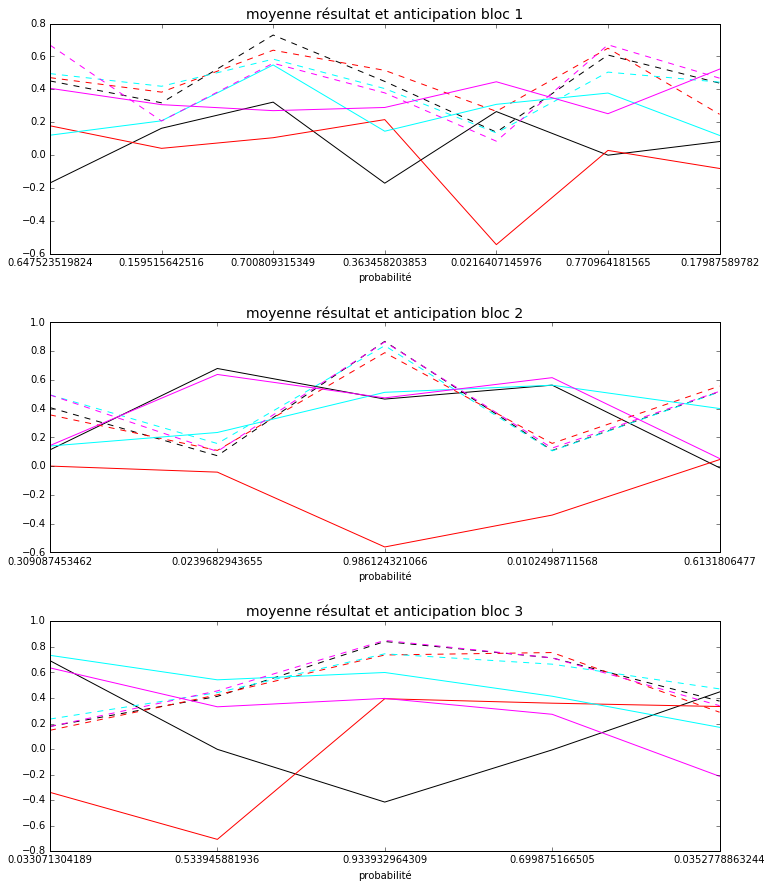

In [6]:
fig_width = 12
fig, axs = plt.subplots(3, 1, figsize=(fig_width, (fig_width*2)/(1.6180)))
fig.subplots_adjust(hspace=0.3)

for x, color in enumerate(['black', 'red', 'cyan', 'magenta']): #, 'cyan', 'magenta', 'green']):

    print(exp[x]['observer'], exp[x]['timeStr'], '=',color )
    
    dic = {}
    N_blocks = exp[x]['N_blocks']
    
    for block in range(N_blocks):

        axs[block].errorbar(range(len(proba_switch_x[x][block])), block_m_result_switch_x[x][block], c=color, linestyle='dashed') #, yerr=block_std_result_switch_x[x][block] 
        axs[block].errorbar(range(len(proba_switch_x[x][block])), block_m_v_anti_switch_x[x][block], c=color) # ,yerr=block_std_v_anti_switch_x[x][block]

        axs[block].set_xticks(np.arange(len(proba_switch_x[x][block])))
        axs[block].set_xticklabels(proba_switch_x[x][block])
        axs[block].set_title('moyenne résultat et anticipation bloc %s'%(block+1), fontsize=14)
        axs[block].set_xlabel('probabilité')

LB 2017-09-19_152205 = black
DC 2017-09-26_162348 = red
IP 2017-09-26_122431 = cyan
BMC 2017-09-25_142503 = magenta


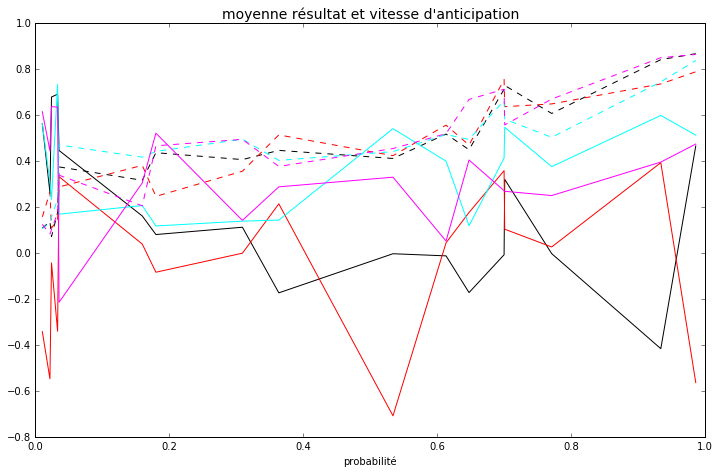

In [7]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width)/1.6180))

for x, color in enumerate(['black', 'red', 'cyan', 'magenta']): #, 'cyan', 'magenta', 'green']):

    print(exp[x]['observer'], exp[x]['timeStr'], '=',color )
    
    dic_m_result = {}
    dic_m_v_anti = {}
    dic_std_result = {}
    dic_std_v_anti = {}
    
    for block in range(N_blocks):
        #print('block', block)
        for s1 in range(len(proba_switch_x[x][block])) :
            dic_m_result[proba_switch_x[x][block][s1]] = block_m_result_switch_x[x][block][s1]
            dic_m_v_anti[proba_switch_x[x][block][s1]] = block_m_v_anti_switch_x[x][block][s1]
            dic_std_result[proba_switch_x[x][block][s1]] = block_std_result_switch_x[x][block][s1]
            dic_std_v_anti[proba_switch_x[x][block][s1]] = block_std_v_anti_switch_x[x][block][s1]
            #print(s1, proba_switch[block][s1], np.correlate(block_result_switch[block][s1], block_v_anti_switch[block][s1])[0])#[0][1])

    m_res = sorted(dic_m_result.items())
    proba = []
    moyenne_resul = []
    m_anti = sorted(dic_m_v_anti.items())
    moyenne_anti = []

    std_res = sorted(dic_std_result.items())
    std_resul = []
    std_anti = sorted(dic_std_v_anti.items())
    std_v_anti = []
    
    for x in range(len(m_res)):
        proba.append(m_res[x][0])
        moyenne_resul.append(m_res[x][1])
        moyenne_anti.append(m_anti[x][1])
        
        std_resul.append(std_res[x][1])
        std_v_anti.append(std_anti[x][1])
        
    #print("\nproba dans l'ordre = ", proba)
    #print("\ncorrelation dans l'ordre = ", correlation)
    plt.errorbar(proba, moyenne_resul, linestyle='dashed', c=color) # , yerr=std_resul
    plt.errorbar(proba, moyenne_anti, c=color) # , yerr=std_v_anti
    plt.title("moyenne résultat et vitesse d'anticipation", fontsize=14)
    plt.xlabel('probabilité')

LB 2017-09-19_152205 = black
DC 2017-09-26_162348 = red
IP 2017-09-26_122431 = cyan
BMC 2017-09-25_142503 = magenta


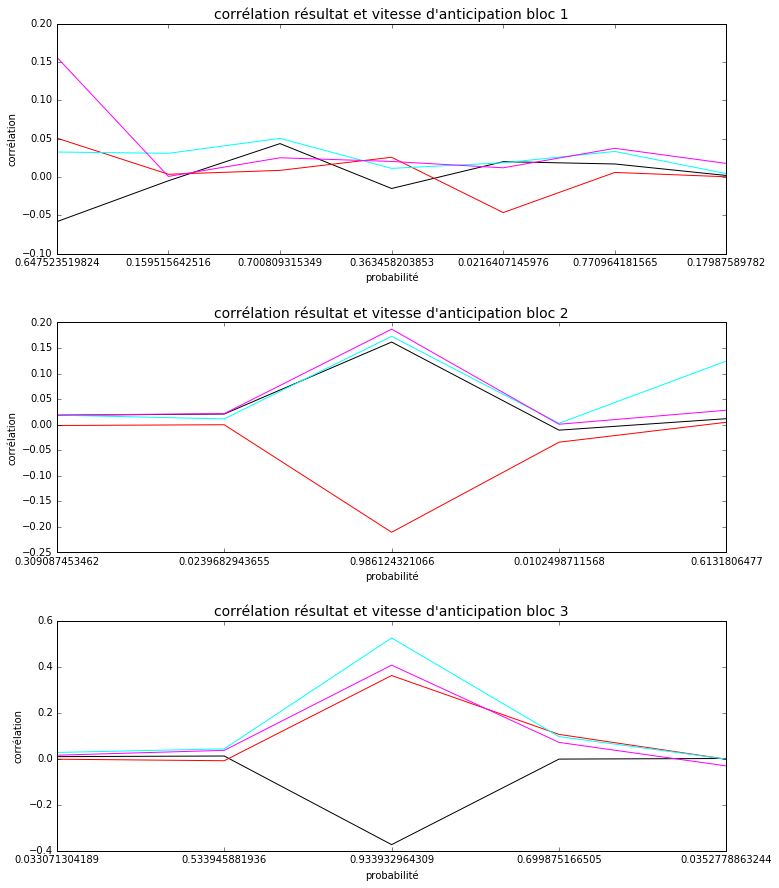

In [8]:
fig_width= 12
fig, axs = plt.subplots(3, 1, figsize=(fig_width, (fig_width*2)/1.6180))
fig.subplots_adjust(hspace=0.3)

for x, color in enumerate(['black', 'red', 'cyan', 'magenta']): #, 'cyan', 'magenta', 'green']):

    print(exp[x]['observer'], exp[x]['timeStr'], '=',color )
    
    dic = {}
    N_blocks = exp[x]['N_blocks']
    
    for block in range(N_blocks):
        #print('block', block)
        corr = []
        for s1 in range(len(proba_switch_x[x][block])) :
            dic[proba_switch_x[x][block][s1]] = np.correlate(block_result_switch_x[x][block][s1], block_v_anti_switch_x[x][block][s1])[0]
            #print(s1, proba_switch_x[x][block][s1], np.correlate(block_result_switch_x[x][block][s1], block_v_anti_switch_x[x][block][s1])[0])#[0][1])
            corr.append(np.correlate(block_result_switch_x[x][block][s1], block_v_anti_switch_x[x][block][s1])[0])#[1])
        axs[block].plot(corr, c=color)
        axs[block].set_xticks(np.arange(len(proba_switch_x[x][block])))
        axs[block].set_xticklabels(proba_switch_x[x][block])
        axs[block].set_title("corrélation résultat et vitesse d'anticipation bloc %s"%(block+1), fontsize=14)
        axs[block].set_xlabel('probabilité')
        axs[block].set_ylabel('corrélation')

LB 2017-09-19_152205 = black
DC 2017-09-26_162348 = red
IP 2017-09-26_122431 = cyan
BMC 2017-09-25_142503 = magenta


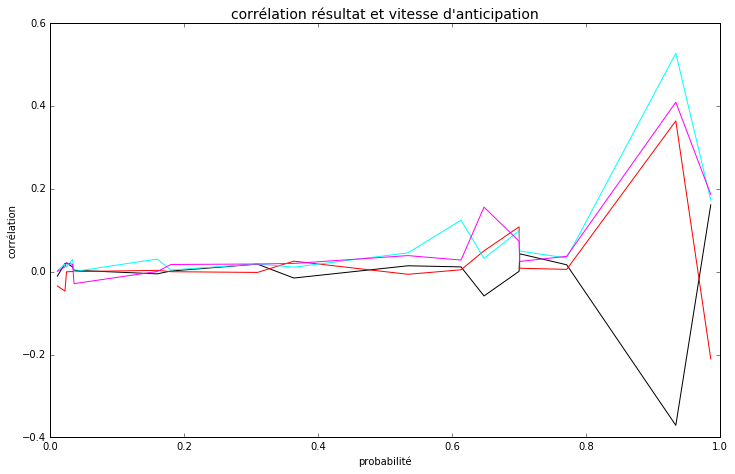

In [9]:
#fig_width = 20
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width)/1.6180))

for x, color in enumerate(['black', 'red', 'cyan', 'magenta']): #, 'cyan', 'magenta', 'green']):

    print(exp[x]['observer'], exp[x]['timeStr'], '=',color )
    
    dic_corr = {}
    N_blocks = exp[x]['N_blocks']
    for block in range(N_blocks):
        #print('block', block)
        for s1 in range(len(proba_switch_x[x][block])) :
            dic_corr[proba_switch_x[x][block][s1]] = np.correlate(block_result_switch_x[x][block][s1], block_v_anti_switch_x[x][block][s1])[0]
            #print(s1, proba_switch_x[x][block][s1], np.correlate(block_result_switch_x[x][block][s1], block_v_anti_switch_x[x][block][s1])[0])#[0][1])

    corr = sorted(dic_corr.items())
    proba = []
    correlation = []
    for x in range(len(corr)):
        proba.append(corr[x][0])
        correlation.append(corr[x][1])
    #print("\nproba dans l'ordre = ", proba)
    #print("\ncorrelation dans l'ordre = ", correlation)
    plt.plot(proba, correlation, c=color)
    plt.title("corrélation résultat et vitesse d'anticipation", fontsize=14)
    plt.ylabel('corrélation')
    plt.xlabel('probabilité')